## author: Levon Abramian, J4132
## Task 3. Algorithms for unconstrained nonlinear optimization. First- and second-order methods

## The use of first- and second-order methods (Gradient Descent, Non-linear, Conjugate Gradient Descent, Newton’s method and Levenberg-Marquardt algorithm) in the tasks of unconstrained nonlinear optimization

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random

from scipy.optimize import minimize, least_squares
    
import warnings
warnings.filterwarnings("ignore")

Limits: $a$ and $b$ is in an interval [0; 1.00]

In [3]:
EPS = 0.001

In [4]:
alpha = random.random()
beta = random.random()
sigma = np.random.normal(size=101)
x_list = np.linspace(0, 1, 101)
y_list = alpha * x_list + beta + sigma

In [5]:
alpha, beta

(0.9621060553598111, 0.4430679148536004)

In [6]:
def linear_approximation(x, a, b):
    return a * x + b


def rational_approximation(x, a, b):
    return a / (1 + b * x)


In [7]:
def loss_linear(params, x, y):
    a, b = params
    predictions = linear_approximation(x, a, b)
    return np.sum((predictions - y) ** 2)


def loss_rational(params, x, y):
    a, b = params
    predictions = rational_approximation(x, a, b)
    return np.sum((predictions - y) ** 2)


In [8]:
# Jacobian of the loss function for Newton's Method
def linear_jacobian(params, x, y):
    a, b = params
    predictions = linear_approximation(x, a, b)
    errors = predictions - y
    da = 2 * np.sum(errors * x)  # dD/da
    db = 2 * np.sum(errors)  # dD/db
    return np.array([da, db])


def rational_jacobian(params, x, y):
    a, b = params
    predictions = rational_approximation(x, a, b)
    errors = predictions - y
    da = 2 * np.sum(errors / (1 + b * x))  # dD/da
    db = 2 * np.sum(errors * (-a * x) / (1 + b * x) ** 2)  # dD/db
    return np.array([da, db])
    

In [9]:
def linear_gradient_descent(x, y, initial_params, lr=0.001, eps=EPS):
    param = np.array(initial_params, dtype=float)  # Ensure params are floats
    steps = []
    steps.append(param)
    for _ in range(10000):  # Limit iterations to prevent infinite loops
        predictions = linear_approximation(x, param[0], param[1])
        errors = predictions - y
        gradient = np.array([
            2 * np.sum(errors * x),  # dL/da
            2 * np.sum(errors)  # dL/db
        ])
        param = param - lr * gradient
        steps.append(param)
        # Check for convergence
        if np.linalg.norm(gradient) < eps:
            break
    return param, steps


def rational_gradient_descent(x, y, initial_params, lr=0.001, eps=EPS):
    param = np.array(initial_params, dtype=float)  # Ensure params are floats
    steps = []
    steps.append(param)
    print(initial_params)
    for _ in range(10000):  # Limit iterations to prevent infinite loops
        predictions = rational_approximation(x, param[0], param[1])
        errors = predictions - y
        gradient = np.array([
            2 * np.sum(errors / (1 + param[1] * x)),  # dL/da
            2 * np.sum(errors * (-param[0] * x) / (1 + param[1] * x) ** 2)  # dL/db
        ])
        param = param - lr * gradient
        steps.append(param)
        # Check for convergence
        if np.linalg.norm(gradient) < eps:
            break
    return param, steps


In [10]:
# Non-linear Conjugate Gradient Descent
def linear_nonlinear_conjugate_gradient(x, y, initial_params):
    result = minimize(loss_linear, initial_params, args=(x, y), method='CG', tol=0.001, options={'gtol':10**-6, 'disp':True, 'return_all':True})
    return result


def rational_nonlinear_conjugate_gradient(x, y, initial_params):
    result = minimize(loss_rational, initial_params, args=(x, y), method='CG', tol=0.001, options={'gtol':10**-6, 'disp':True, 'return_all':True})
    return result
    

In [11]:
# Newton's Method with Jacobian
def linear_newtons_method(x, y, initial_params):
    result = minimize(loss_linear, initial_params, args=(x, y), method='BFGS', jac=linear_jacobian, tol=0.001, options={'gtol':10**-6, 'disp':True, 'return_all':True})
    return result

# Newton's Method with Jacobian
def rational_newtons_method(x, y, initial_params):
    result = minimize(loss_rational, initial_params, args=(x, y), method='BFGS', jac=rational_jacobian, tol=0.001, options={'gtol':10**-6, 'disp':True, 'return_all':True})
    return result
    

In [12]:
# Newton's Method with Jacobian
def linear_neldermead_method(x, y, initial_params):
    result = minimize(loss_linear, initial_params, args=(x, y), method='Nelder-Mead', jac=linear_jacobian, tol=0.001, options={'gtol':10**-6, 'disp':True, 'return_all':True})
    return result

# Newton's Method with Jacobian
def rational_neldermead_method(x, y, initial_params):
    result = minimize(loss_rational, initial_params, args=(x, y), method='Nelder-Mead', jac=rational_jacobian, tol=0.001, options={'gtol':10**-6, 'disp':True, 'return_all':True})
    return result
    

In [13]:
class Point:

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __add__(self, other):
        x = self.x + other.x
        y = self.y + other.y
        return Point(x, y)

    def __hash__(self):
        return 1

    def __str__(self):
        return f'{self.x}, {self.y}'

    def __repr__(self):
        return f'{self.x}, {self.y}'

    def __rmul__(self, other):
        x = self.x * other
        y = self.y * other
        return Point(x, y)

    def __truediv__(self, other):
        x = self.x / other
        y = self.y / other
        return Point(x, y)

    def __sub__(self, other):
        x = self.x - other.x
        y = self.y - other.y
        return Point(x, y)


def D(a, b, F):
    D = 0
    for xi, yi in zip(x_list, y_list):
        D += (F(xi, a, b) - yi) ** 2
    return D

def exhaustive_search_2D(func, start_point: Point, finish_point: Point, eps, F):
    min_point, min_value = start_point, func(start_point.x, start_point.y, F)

    current_point = start_point
    n_iter = 0
    
    while finish_point.x - current_point.x > eps:
        while finish_point.y - current_point.y > eps:
            n_iter += 1
    
            current_value = func(current_point.x, current_point.y, F)
            
            if current_value < min_value:
                min_point, min_value = current_point, current_value
            
            current_point = Point(current_point.x, current_point.y + eps)

        current_point = Point(current_point.x + eps, start_point.y)

    return min_point, n_iter

In [14]:
def dichotomy_search(func, a, b, eps):
    n_iter = 0
    
    while abs(a - b) > eps:
        n_iter += 1
        
        if func(a) < func(b):
            b = (a + b) / 2
        else:
            a = (a + b) / 2

    return (a + b) / 2, n_iter

def gauss_search(func, start_point: Point, finish_point: Point, eps, F):
    optim_point = start_point
    n_iter = 0
    cur_min_value = func(start_point.x, start_point.y, F)
    while True:
        cur_func = lambda x: func(optim_point.x, x, F)
        y_inner_point, iters = dichotomy_search(cur_func, start_point.y, finish_point.y, eps)
        n_iter += iters
        if abs(optim_point.y - y_inner_point) < eps:
            break
        
        optim_point = Point(optim_point.x, y_inner_point)

        cur_func =  lambda x: func(x, optim_point.y, F)
        x_inner_point, iters = dichotomy_search(cur_func, start_point.x, finish_point.x, eps)
        n_iter += iters
        if abs(optim_point.x - x_inner_point) < eps:
            break
        optim_point = Point(x_inner_point, optim_point.y)
    
    return optim_point, n_iter

In [15]:
# Levenberg-Marquardt
def linear_levenberg_marquardt(x, y, initial_params):
    def residuals(params):
        return linear_approximation(x, params[0], params[1]) - y
    
    result = least_squares(residuals, initial_params, method='lm', verbose=1)
    
    return result


# Levenberg-Marquardt
def rational_levenberg_marquardt(x, y, initial_params):
    def residuals(params):
        return rational_approximation(x, params[0], params[1]) - y
    
    result = least_squares(residuals, initial_params, method='lm', verbose=1)
    
    return result

Gradient Descent parameters: a=1.1200, b=0.4027


Text(0.5, 1.0, 'Linear Approximation Gradient Descent')

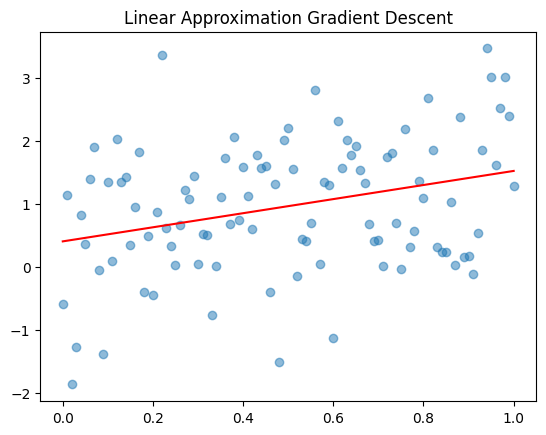

In [16]:
# Initial parameter guesses
initial_params = [0.1, 0.1]

linear_params_gd, list_linear_params_gd = linear_gradient_descent(x_list, y_list, initial_params)

print(f"Gradient Descent parameters: a={linear_params_gd[0]:.4f}, b={linear_params_gd[1]:.4f}")

plt.scatter(x_list, y_list, label='Noisy Data', alpha=0.5)
plt.plot(x_list, linear_approximation(x_list, *linear_params_gd), color='red', label='Gradient Descent Fit')
plt.title('Linear Approximation Gradient Descent')

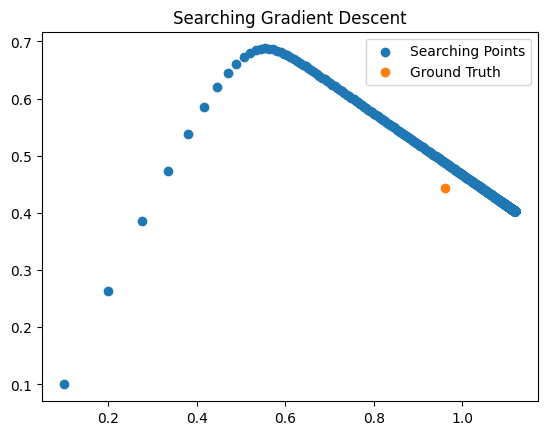

In [17]:
xs = [point[0] for point in list_linear_params_gd]
ys = [point[1] for point in list_linear_params_gd]
plt.scatter(xs, ys, label='Searching Points')
plt.scatter(alpha, beta, label='Ground Truth')
plt.title('Searching Gradient Descent')
plt.legend()

[0.1, 0.1]
Gradient Descent parameters: a=0.5567, b=-0.6989


Text(0.5, 1.0, 'Rational Approximation Gradient Descent')

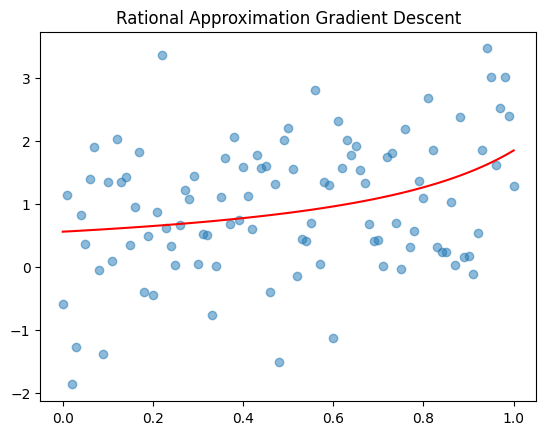

In [18]:
# Initial parameter guesses
initial_params = [0.1, 0.1]

rational_params_gd, list_rational_params_gd = rational_gradient_descent(x_list, y_list, initial_params)

print(f"Gradient Descent parameters: a={rational_params_gd[0]:.4f}, b={rational_params_gd[1]:.4f}")

plt.scatter(x_list, y_list, label='Noisy Data', alpha=0.5)
plt.plot(x_list, rational_approximation(x_list, *rational_params_gd), color='red', label='Gradient Descent Fit')
plt.title('Rational Approximation Gradient Descent')

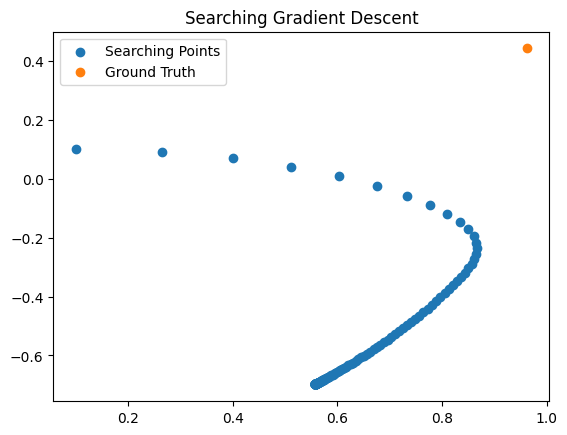

In [19]:
xs = [point[0] for point in list_rational_params_gd]
ys = [point[1] for point in list_rational_params_gd]
plt.scatter(xs, ys, label='Searching Points')
plt.scatter(alpha, beta, label='Ground Truth')
plt.title('Searching Gradient Descent')
plt.legend()

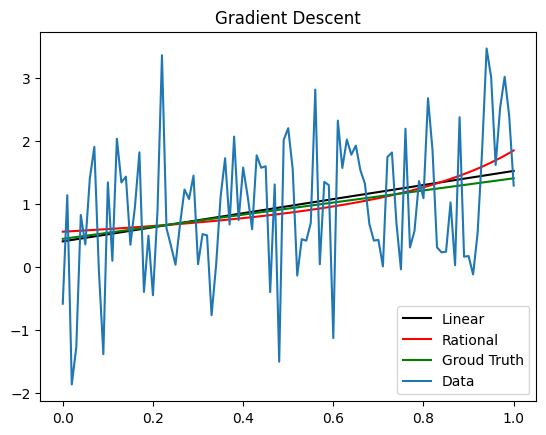

In [20]:
plt.plot(x_list, linear_approximation(x_list, *linear_params_gd), color='black', label='Linear')
plt.plot(x_list, rational_approximation(x_list, *rational_params_gd), color='red', label='Rational')
plt.plot(x_list, linear_approximation(x_list, alpha, beta), color='green', label='Groud Truth')
plt.title('Gradient Descent')
plt.plot(x_list, y_list, label='Data')
plt.legend()

Optimization terminated successfully.
         Current function value: 101.895596
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5


Text(0.5, 1.0, 'Linear Approximation Nonlinear Conjugate Gradient')

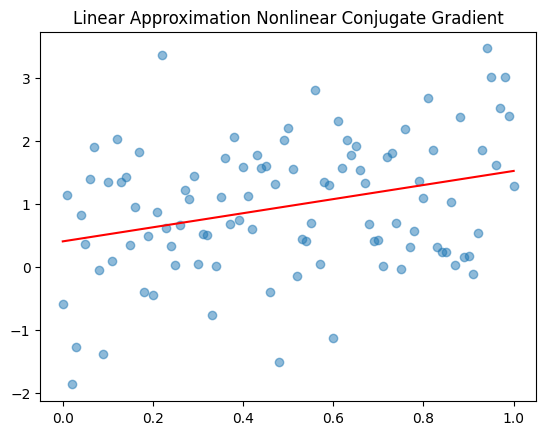

In [21]:
linear_cg_params = linear_nonlinear_conjugate_gradient(x_list, y_list, initial_params)

plt.scatter(x_list, y_list, label='Noisy Data', alpha=0.5)
plt.plot(x_list, linear_approximation(x_list, *linear_cg_params.x), color='red', label='Gradient Descent Fit')
plt.title('Linear Approximation Nonlinear Conjugate Gradient')

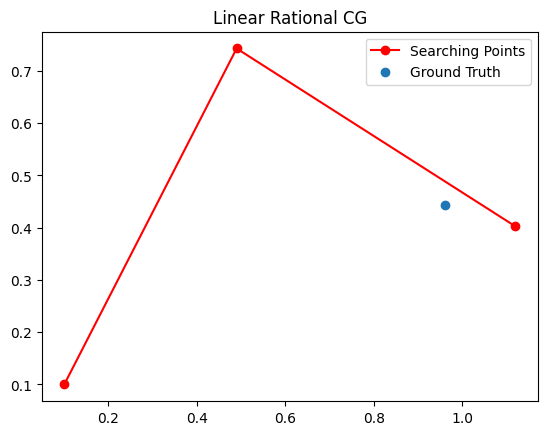

In [22]:
xs = [point[0] for point in linear_cg_params.allvecs]
ys = [point[1] for point in linear_cg_params.allvecs]
plt.plot(xs, ys, label='Searching Points', marker='o', color='r')
plt.scatter(alpha, beta, label='Ground Truth')
plt.title('Linear Rational CG')
plt.legend()

Optimization terminated successfully.
         Current function value: 101.505238
         Iterations: 12
         Function evaluations: 99
         Gradient evaluations: 33


Text(0.5, 1.0, 'Rational Approximation Nonlinear Conjugate Gradient')

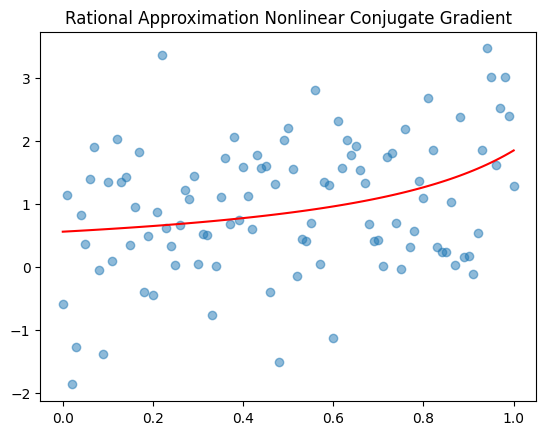

In [23]:
rational_cg_params = rational_nonlinear_conjugate_gradient(x_list, y_list, initial_params)

plt.scatter(x_list, y_list, label='Noisy Data', alpha=0.5)
plt.plot(x_list, rational_approximation(x_list, *rational_cg_params.x), color='red', label='Gradient Descent Fit')
plt.title('Rational Approximation Nonlinear Conjugate Gradient')

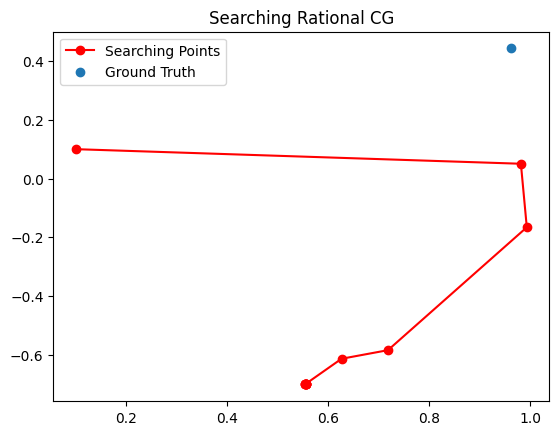

In [24]:
xs = [point[0] for point in rational_cg_params.allvecs]
ys = [point[1] for point in rational_cg_params.allvecs]
plt.plot(xs, ys, label='Searching Points', marker='o', color='r')
plt.scatter(alpha, beta, label='Ground Truth')
plt.title('Searching Rational CG')
plt.legend()

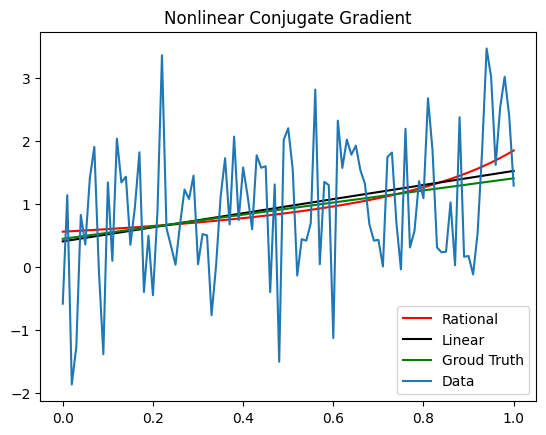

In [25]:
# plt.scatter(x_list, y_list, label='Noisy Data', alpha=0.5)
plt.plot(x_list, rational_approximation(x_list, *rational_cg_params.x), color='red', label='Rational')
plt.plot(x_list, linear_approximation(x_list, *linear_cg_params.x), color='black', label='Linear')
plt.plot(x_list, linear_approximation(x_list, alpha, beta), color='green', label='Groud Truth')
plt.title('Nonlinear Conjugate Gradient')
plt.plot(x_list, y_list, label='Data')
plt.legend()

Optimization terminated successfully.
         Current function value: 101.895596
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6


Text(0.5, 1.0, 'Linear Approximation Newton')

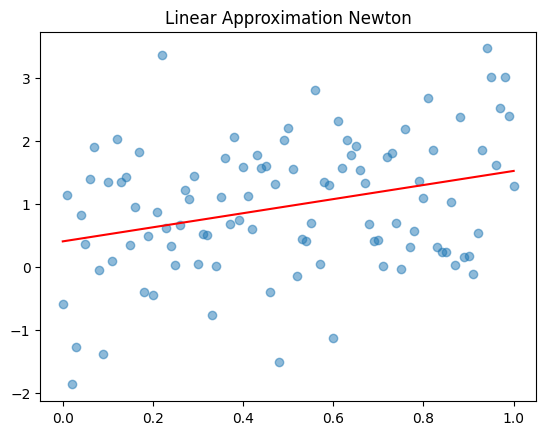

In [26]:
linear_newton_params = linear_newtons_method(x_list, y_list, initial_params)

plt.scatter(x_list, y_list, label='Noisy Data', alpha=0.5)
plt.plot(x_list, linear_approximation(x_list, *linear_newton_params.x), color='red', label='Gradient Descent Fit')
plt.title('Linear Approximation Newton')

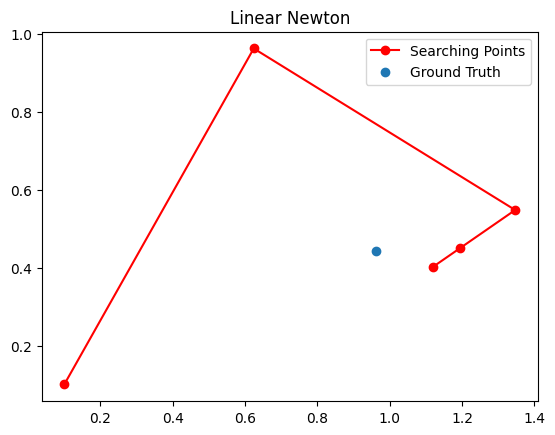

In [27]:
xs = [point[0] for point in linear_newton_params.allvecs]
ys = [point[1] for point in linear_newton_params.allvecs]
plt.plot(xs, ys, label='Searching Points', marker='o', color='r')
plt.scatter(alpha, beta, label='Ground Truth')
plt.title('Linear Newton')
plt.legend()

Optimization terminated successfully.
         Current function value: 101.505238
         Iterations: 13
         Function evaluations: 18
         Gradient evaluations: 18


Text(0.5, 1.0, 'Rational Approximation Newton')

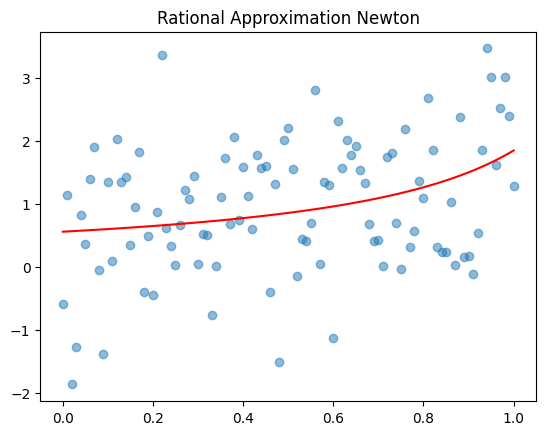

In [28]:
rational_newton_params = rational_newtons_method(x_list, y_list, initial_params)

plt.scatter(x_list, y_list, label='Noisy Data', alpha=0.5)
plt.plot(x_list, rational_approximation(x_list, *rational_newton_params.x), color='red', label='Gradient Descent Fit')
plt.title('Rational Approximation Newton')

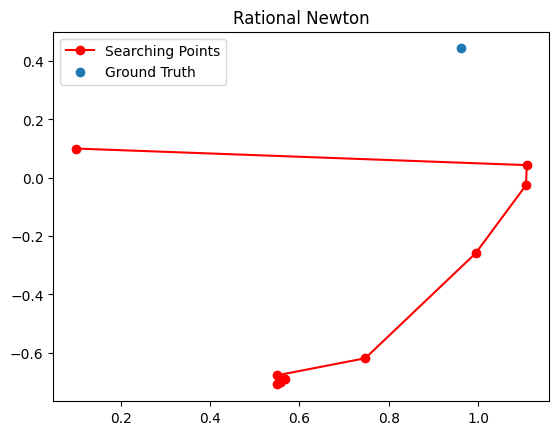

In [29]:
xs = [point[0] for point in rational_newton_params.allvecs]
ys = [point[1] for point in rational_newton_params.allvecs]
plt.plot(xs, ys, label='Searching Points', marker='o', color='r')
plt.scatter(alpha, beta, label='Ground Truth')
plt.title('Rational Newton')
plt.legend()

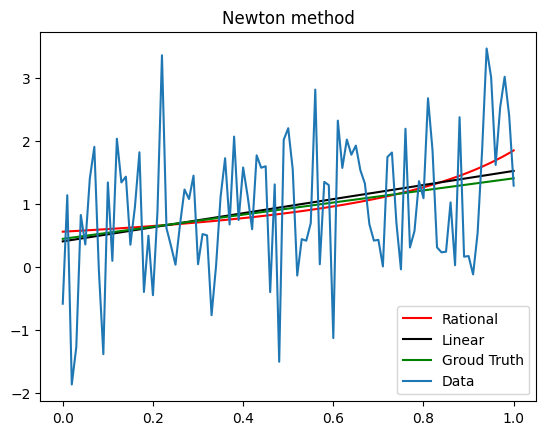

In [30]:
# plt.scatter(x_list, y_list, label='Noisy Data', alpha=0.5)
plt.plot(x_list, rational_approximation(x_list, *rational_newton_params.x), color='red', label='Rational')
plt.plot(x_list, linear_approximation(x_list, *linear_newton_params.x), color='black', label='Linear')
plt.plot(x_list, linear_approximation(x_list, alpha, beta), color='green', label='Groud Truth')
plt.title('Newton method')
plt.plot(x_list, y_list, label='Data')
plt.legend()

`gtol` termination condition is satisfied.
Function evaluations 6, initial cost 8.8771e+01, final cost 5.0948e+01, first-order optimality 8.99e-07.


Text(0.5, 1.0, 'Linear Approximation Levenberg-Marquardt')

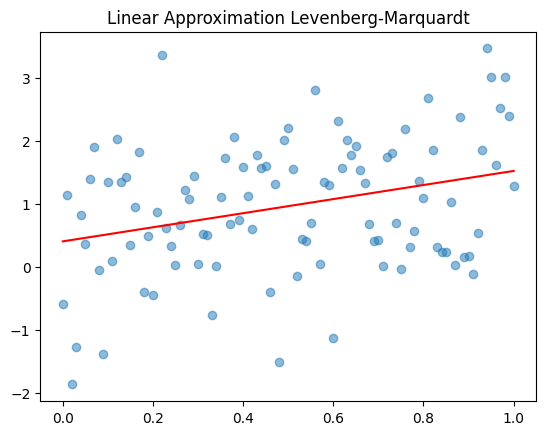

In [31]:
linear_lm_params = linear_levenberg_marquardt(x_list, y_list, initial_params)

plt.scatter(x_list, y_list, label='Noisy Data', alpha=0.5)
plt.plot(x_list, linear_approximation(x_list, *linear_lm_params.x), color='red', label='Gradient Descent Fit')
plt.title('Linear Approximation Levenberg-Marquardt')

`ftol` termination condition is satisfied.
Function evaluations 24, initial cost 9.4418e+01, final cost 5.0753e+01, first-order optimality 1.40e-03.


Text(0.5, 1.0, 'Rational Approximation Levenberg-Marquardt')

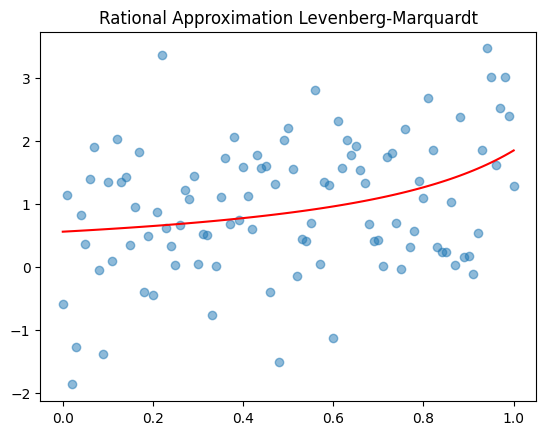

In [32]:
rational_lm_params = rational_levenberg_marquardt(x_list, y_list, initial_params)

plt.scatter(x_list, y_list, label='Noisy Data', alpha=0.5)
plt.plot(x_list, rational_approximation(x_list, *rational_lm_params.x), color='red', label='Gradient Descent Fit')
plt.title('Rational Approximation Levenberg-Marquardt')

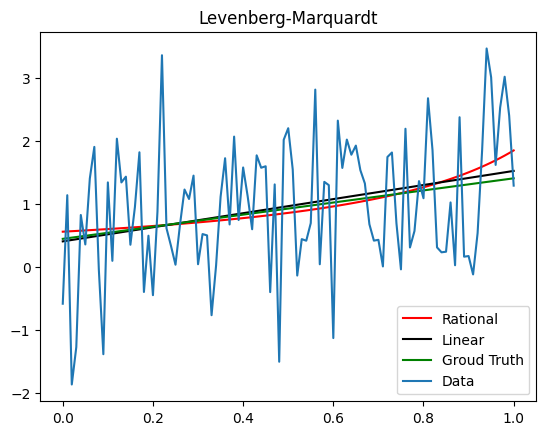

In [33]:
plt.plot(x_list, rational_approximation(x_list, *rational_lm_params.x), color='red', label='Rational')
plt.plot(x_list, linear_approximation(x_list, *linear_lm_params.x), color='black', label='Linear')
plt.plot(x_list, linear_approximation(x_list, alpha, beta), color='green', label='Groud Truth')
plt.title('Levenberg-Marquardt')
plt.plot(x_list, y_list, label='Data')
plt.legend()

In [34]:
linear_neldermead_params = linear_neldermead_method(x_list, y_list, initial_params)
rational_neldermead_params = rational_neldermead_method(x_list, y_list, initial_params)

Optimization terminated successfully.
         Current function value: 101.895597
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: 101.505259
         Iterations: 40
         Function evaluations: 77


In [35]:
min_point_gauss_1, interation_gauss_1 = gauss_search(D, Point(0, 0), Point(1, 1), eps=0.001, F=linear_approximation)
min_point_gauss_2, interation_gauss_2 = gauss_search(D, Point(0, 0), Point(1, 1), eps=0.001, F=rational_approximation)

It can be seen that the results for all methods are the same in terms of the accuracy of finding the optimum point. For example, the figures above show this well. But you can also see that the iteration number is different. Next, let's see how the iteration number is related to each other.

# Comparision

There is no any reason to use exhaustive search iterations because it is too large number (1e6).

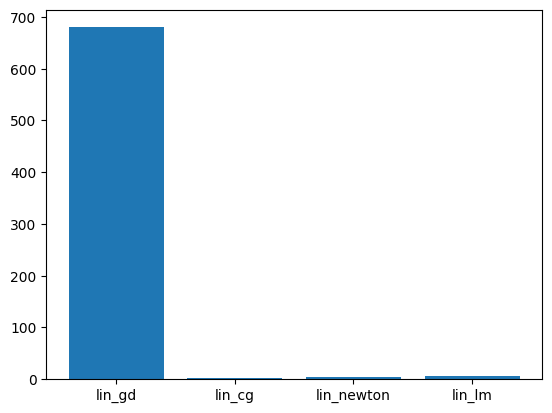

In [36]:
d_lin = {
    'lin_gd': len(list_linear_params_gd),
    'lin_cg': len(linear_cg_params.allvecs),
    'lin_newton': len(linear_newton_params.allvecs),
    'lin_lm': linear_lm_params.nfev,
    # 'lin_md': len(linear_neldermead_params.allvecs),
    # 'lin_exh': interation_exs_1,
    # 'lin_gauss': interation_gauss_1,
}
plt.bar(d_lin.keys(), d_lin.values());

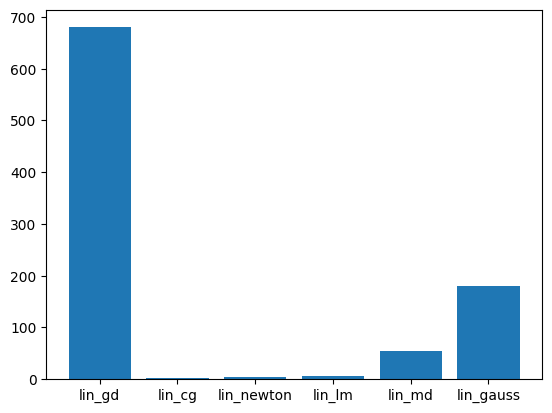

In [37]:
d_lin = {
    'lin_gd': len(list_linear_params_gd),
    'lin_cg': len(linear_cg_params.allvecs),
    'lin_newton': len(linear_newton_params.allvecs),
    'lin_lm': linear_lm_params.nfev,
    'lin_md': len(linear_neldermead_params.allvecs),
    # 'lin_exh': interation_exs_1
    'lin_gauss': interation_gauss_1
}
plt.bar(d_lin.keys(), d_lin.values());

The plots show that the first and second orders methods did less iteration except the Gradient Descent. Gradint Desecnt has a hyperparameter such a learning rate and it is should be select carefully. Also, don't forget the first and second methods do more complex calculations and require calculate gradient, hessian or jacobian.


<BarContainer object of 4 artists>

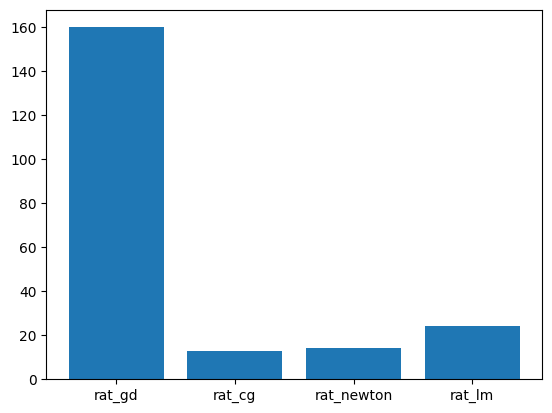

In [38]:
d_rational = {
    'rat_gd': len(list_rational_params_gd),
    'rat_cg': len(rational_cg_params.allvecs),
    'rat_newton': len(rational_newton_params.allvecs),
    'rat_lm': rational_lm_params.nfev,
    # 'rat_md': len(linear_neldermead_params.allvecs),
    # 'rat_exh': interation_exs_2
    # 'rat_gauss': interation_gauss_2
}
plt.bar(d_rational.keys(), d_rational.values())

<BarContainer object of 6 artists>

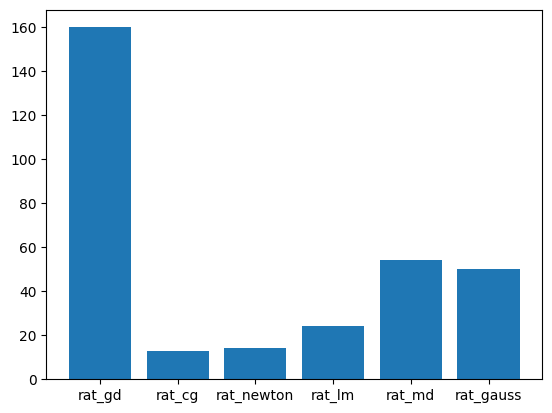

In [39]:
d_rational = {
    'rat_gd': len(list_rational_params_gd),
    'rat_cg': len(rational_cg_params.allvecs),
    'rat_newton': len(rational_newton_params.allvecs),
    'rat_lm': rational_lm_params.nfev,
    'rat_md': len(linear_neldermead_params.allvecs),
    # 'rat_exh': interation_exs_2
    'rat_gauss': interation_gauss_2
}
plt.bar(d_rational.keys(), d_rational.values())

# Conclusion

Obtained results confirm the theoretical rules. For the getting difference optimal point better to made stopping option as maximum of iteration or calculation. There was shown that it is needed to select learning rate for Gradient Descent, and the  first- and second-order methods work better than direct methods by number of iteration metrics.